<a href="https://colab.research.google.com/github/MelihKlc/Deep-Learning/blob/main/Milestone_Project_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

# Get data

Since we will be replicating the paper above (PubMed 200k RCT) , lets download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct  # Githubdan data cekerken git clone kullanıyoruz

!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 29.46 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# 20K dataset koymalarının sebebi önce kücük datasette calısıp sonrasında upscale etmek. (%10 of original dataset)
# Check the files are in the PubMed_20k_ dataset
# Dev.txt aslında validation set için konulan başka bir isim
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/   # Burda sayılar yerine @ konulmus sekilde geliyo datasetimiz. Aslında preprocess edilmis oluyo bir kısmı.

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20K dataset with number replaced by "@" sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check all of the filenames in the target directory.
import os

filenames = [ data_dir + filename for filename in os.listdir(data_dir) ]
filenames

#for döngüsünden sonra gelen filename, her bir döngü iterasyonunda listenin içindeki dosya ve dizin adlarını temsil eden bir değişkendir. Yani her döngü adımında filename değişkeni, listenin içindeki sıradaki dosya veya dizin adını alır.

#Örneğin, eğer os.listdir(data_dir) çağrısıyla data_dir dizininde bulunan dosya ve dizin adları şunlar ise: ['dosya1.txt', 'dosya2.txt', 'alt_dizin']

#for filename in os.listdir(data_dir) ifadesi döngüye başladığında filename şu değerleri alacaktır:

#İterasyon 1: filename = 'dosya1.txt'
#İterasyon 2: filename = 'dosya2.txt'
#İterasyon 3: filename = 'alt_dizin'

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preprocess data

Now we have got some text data , it is time to become one with it.

And one of the best ways to become one with the data is to..

> Visualize

So with that in mind , lets write a function to read in all of the lines of a target text file

In [5]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  # r means read and f means file. Open this file(filename) and save it as f
  with open(filename , "r") as f:
    return f.readlines()  # This reads the remaining lines from the file object and returns them as a list.


In [6]:
# Lets read in the training lines

train_lines = get_lines(data_dir + "train.txt" )
train_lines[ : 27 ]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Lets think about how we want out data to look..

How i think our data would be best represented..

We will represent our data with dictionary

Emotional eatingle baslayan yeri kullanıyoruz.

'  [ {  ' line_number ' : 0  ,
' target ' : ' BACKGROUND ' ,
' text ' : "BACKGROUND\tEmotional eating is associated with overeating and the development of obesity .\n" ,
' total_lines ' : 11  (sentence in our special abstract) }]  '

Bizim datamızda order önemli çünkü conclusion cümlesinin başta olması saçma olur bu yüzden ordera dikkat edeceğiz.

Bunu bitirdiğimizde liste içinde 11 dictionarymiz olması gerek.

Niye bunu kullanıyoruz? Çünkü pythonda kendi data structure ımızı oluşturmak çok önemli şu an datamızda bir structure yok bu yüzden biz bunu list of dictionaries structure ına çevireceğiz.



# Lets write a function which turns each of our datasets into the above format so we can continue to prepare

In [7]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstarct line data.

  Takes in filename , reads in contents and sorts through each line ,
  extracting things like the target label , the text of the sentence ,
  how many sentences are in the current abstract and what sentence number
  the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract. abstractlar \n ile ayrıldıgı icin biz de burda abstractları ayırıyoruz.
  abstract_samples = [] # Create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):  # Check to see if the line is an ID line. Bu methodla ### ile başlayan line gelirse yi test ediyoruz.
      abstract_id = line
      abstract_lines = ""   # Reset the abstract string if the line is an ID line. Yani id line geldiginde abstractımızı resetleyip basta yaptıgımız isleme dönüyoruz.
    elif line.isspace():  # Check to see if line is a new line. Artık buraya geldiğimizde abstractları ayırdık. Simdi de abstract içindeki cümleleri ayırmamız gerekiyor. Bu yüzden isspace kullanıyoruz bu da new line gördüğünde devreye giriyor yani \n gördüğünde.
      abstract_line_split = abstract_lines.splitlines()  # Split abstract into seperate lines. splitlines fonksiyonu ile \n yani new line gördüğünde artık onu line olarak ayarlıyor ve aşağıya geçtiğinde farklı bir line a geçmiş oluyoruz.

         # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
          line_data = {}  # Create an empty dictionary for each line. Her line için yukarıda bir pattern yazmıştık onu oluşturuyoruz.
          target_text_split = abstract_line.split("\t") # Split target label from text
          line_data["target"] = target_text_split[0] # Get target labels. target_text_split ile textimizi labelından ayırdık. Şimdi line_data adında bir data olusturduk yukarıda dictionary olarak ve buna target adında bir feature ekledik bu labelları tutacak içinde. target_text_split[0] 0. index dediğimiz zaten labellar oluyo biz 2 indexe ayırdık target ve text olarak.
          line_data["text"] = target_text_split[1].lower()  # Textteki tüm harfleri kücük harfe ceviriyoruz lower methodu ile.
          line_data["line_number"] = abstract_line_number # What number line does the line appear in the abstract.
          line_data["total_lines"] = len(abstract_line_split) - 1  # -1 , indexler 0 dan basladıgı icin. How many total lines are there in the target abstract?
          abstract_samples.append(line_data)  # add line data to abstract sample list. Burda artık line_data ile gerekli dictionary mizi olusturduk simdi list of dictionary kullanacagımız icin en basta olusturdugumuz empty listeye dictionarymizi ekliyoruz.
    else:
      abstract_lines += line  # If the above conditions arent satisfied , the line contains a labelled sentence . If it is not an id line (doesnt begin with ###) and if it also is not an empty string, the else statement is saying all of these lines between the ### and between the new line (\n) are part of the same abstract
  return abstract_samples

In [8]:
# Get data from file and preprocess it. (%%time ne kadar surdugunu ogrenmek icin)
%%time
train_samples = preprocess_text_with_line_numbers(data_dir +"train.txt")
train_samples[ : 20]


CPU times: user 577 ms, sys: 74.9 ms, total: 652 ms
Wall time: 879 ms


[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [9]:
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
test_samples[ : 30]

[{'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'line_number': 0,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'line_number': 1,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'line_number': 2,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ %

# Now that our data is the format of a list of dictionaries , how about we turn into a DataFrame to further vision

In [10]:
import pandas as pd   # Bizim datalarımızı dictionary formata getirme sebeplerimizin birisi de dictlerin pandas ile DataFrame şekline kolay çevrilebilmesi.
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

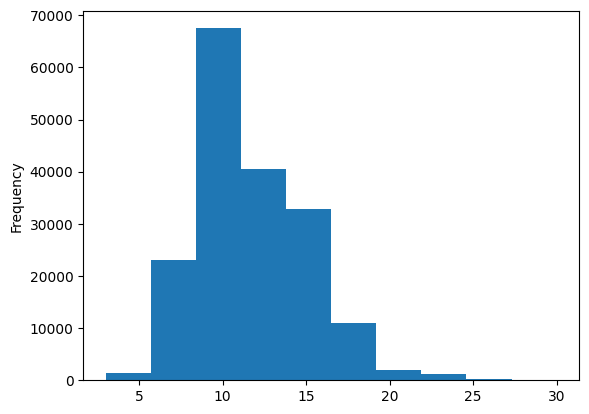

In [12]:
# Lets check the length of different lines
train_df.total_lines.plot.hist();

# Get list of sentences

In [13]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [14]:
# View the 10 lines of training sentences
train_sentences[ : 10]


['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numeric labels (ML models require numeric labels)

# First we will encode with one hot encoder and then we will use label encoder

In [15]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse = False)  # We want non-sparse matrix

train_labels_encoded = encoder.fit_transform(train_df["target"].to_numpy().reshape( -1 , 1 )) # Reshape yapmamız gerekiyor cünkü 2d array bekleniyor input olarak
train_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
val_labels_encoded = encoder.transform(val_df["target"].to_numpy().reshape( -1  , 1))
test_labels_encoded = encoder.transform(test_df["target"].to_numpy().reshape( -1  , 1))
# We wont use fit again because we already fitted in train_labels_encoded our encoder object , so fitting val and test labels are unnecessary

# Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
encoder_2 = LabelEncoder()

train_labels_encoded_labelencoder = encoder_2.fit_transform(train_df["target"].to_numpy())
val_labels_encoded_labelencoder = encoder_2.transform(val_df["target"].to_numpy())
test_labels_encoded_labelencoder = encoder_2.transform(test_df["target"].to_numpy())

In [18]:
test_labels_encoded_labelencoder[ : 10]

array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(encoder_2.classes_)
class_names = encoder_2.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Starting a series of modelling experiments

As usual , we are going to be trying out a bunch of different models and seeing which one works best.

And as always , we are going to start with a baseline (TF-IDF multinomial naive bayes)

# Model 0 : Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline

model_0 = Pipeline( [

                   ("tfidf" , TfidfVectorizer()) ,
                   ("clf" , MultinomialNB())
]
)

# Fit the pipeline to the training data
model_0.fit(
    X =  train_sentences ,
 y =   train_labels_encoded_labelencoder

)
# TfidfVectorizer terim frekansı ters belge frekansı (TF-IDF) değerlerini hesaplamak için kullanılır. Bu yöntem, bir belge içerisindeki bir terimin önemini, hem belge içerisindeki sıklığına hem de tüm belgelerdeki görülme sıklığına dayalı olarak belirler. Bu sayede metinlerin içerdikleri kelimelerin anlamlılığını belirlemek için kullanılır.
# MultinomialNB, çok sınıflı Bayes sınıflandırıcılarından biridir ve metin sınıflandırma gibi problemlerde kullanılır. Naive Bayes algoritması, Bayes teoremi temel alınarak çalışır ve bir metni belirli sınıflara tahmin etmek için metindeki özelliklerin olasılıklarını kullanır. Bu durumda, sınıflandırıcı, veri setindeki sınıfları tahmin etmek için metin özelliklerini (TF-IDF değerleri) kullanacaktır.

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation set
model_0.score(
    X = val_sentences ,
    y = val_labels_encoded_labelencoder
)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

# We will compare predictions across different metrics (accuracy , precision , recall , f1-score)



In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [24]:
baseline_results = calculate_results(
    y_true = val_labels_encoded_labelencoder ,
    y_pred = baseline_preds

)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 1: Conv1D with token embeddings

# Create a text vectorizer layer

We want to make a layer which maps our texts from words to number

In [25]:
# How long is each sentence on average?
import numpy as np
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

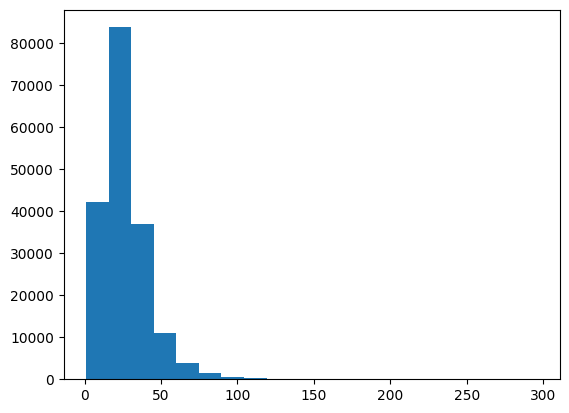

In [26]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [27]:
# Find the average number of tokens in the training texts
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

26

In [28]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len  # output length kaç seçersek bizim datamızın %95 ini kapsar?

55

In [29]:
# How many word are in our vocab? (taken from table 2 in our dataset paper , we have 68000 words)
max_tokens = 68000

In [30]:
# We will create our textvectorizer function for convertinf text into numbers

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#ngram substringleri birleştiriyor. Mesela elimizde 'Imagine getting flattened by Kurt Zouma' cümlesi var. ngram = 2 dersek , "Image getting" , "flattened by" , "Kurt Zouma"  gibi ikişer ikişer substringleri birleştiriyor.

# Default values of TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens , # How many words in the vocabulary ( automatically add <00V>)
                                                       output_sequence_length = 55 , # Desired lenght of vectorized output length of vectorized sequences
                                    )

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\n Length of text : {len(target_sentence.split())}\n")
print(f"Text vectorized form of the text : \n{text_vectorizer([target_sentence])}")

Text:
the maximum implant insertion torque ( mit ) was measured as an index of primary implant stability .

 Length of text : 18

Text vectorized form of the text : 
[[    2   635  1517  1395  4257 20165    10   156    25    26   203     4
     56  1517  1714     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [33]:
# How many words in our training vocab?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in our vocab : {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab : { rct_20k_text_vocab[ :  5 ] }")
print(f"Least common words in the vocab : { rct_20k_text_vocab[ -5 : ] }")


Number of words in our vocab : 64841
Most common words in the vocab : ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

# Create an embedding layer

In [35]:
from tensorflow.keras import layers

embedding = layers.Embedding( input_dim = len(rct_20k_text_vocab) ,  # set input shape
                              output_dim = 128 , # Output shape. Every token in the format of 128 long vector
                              mask_zero = True  # Input length 55 dedigimiz icin uzun cümlelerin sonunda 0 lar kalacak . Tensorflow to do more efficient computing when there is lots of zeros.
                              )

In [36]:
# Show example embedding
# Cümleyi embed etmeden önce kesinlikle numerical form lazım bize o yüzden text vectorizationdan geçirmeden embedding yapamıyoruz.
print(f"Sentence before vectorization: \n {target_sentence}")
vectorized_sentence = text_vectorizer ([target_sentence])
print(f"\nVectorized form of our sentence (before embedding) : \n {vectorized_sentence}")
embedded_sentence = embedding(vectorized_sentence)
print(f"\nEmbedded form of our sentence : \n {embedded_sentence}")
print(f"\nShape of embedded form of sentence \n : {embedded_sentence.shape} ")

Sentence before vectorization: 
 the maximum implant insertion torque ( mit ) was measured as an index of primary implant stability .

Vectorized form of our sentence (before embedding) : 
 [[    2   635  1517  1395  4257 20165    10   156    25    26   203     4
     56  1517  1714     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded form of our sentence : 
 [[[-0.00379528 -0.02275317  0.00298154 ... -0.00358812  0.03551339
   -0.03464429]
  [ 0.04525698 -0.00947792  0.00564002 ...  0.04810395  0.03644322
   -0.01902914]
  [-0.00403656 -0.02309213 -0.00379054 ...  0.01027398  0.03423679
    0.04593349]
  ...
  [-0.04746889 -0.01614915 -0.02511807 ...  0.01439456  0.04019358
    0.02917724]
  [-0.04746889 -0.01614915 -0.02511807 ...  0.01439456  0.04019358
    0.02917724]
  [-0.047468

# Creating datasets (making sure our data loads as fast as possible)

We are going to setup our data to run as fast as possible with tensorflow tf.data API , many of the steps here are discussed at length in these two resources:

https://www.tensorflow.org/guide/data_performance

https://www.tensorflow.org/guide/data

In [38]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_encoded))

# It combines them into tensorflow slice dataset

In [39]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

#Shuffle etmiyoruz cünkü bu datamızda önceden bahsettiğimiz üzere order önemli.

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [41]:
num_classes

5

In [40]:
# Create model_1

inputs = layers.Input(shape = (1,) , dtype  = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(128 , kernel_size = 5 , activation = "relu" , padding = "same")(x)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector from conv layer
outputs = layers.Dense( num_classes , activation = "softmax")(x)

model_1 = tf.keras.Model(inputs , outputs)

# Compile a model

model_1.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )

# Fit the model
hist_1 = model_1.fit(
    train_dataset ,
    epochs = 5 ,  # Eğer daha hızlı process istiyorsak burda steps_per_epoch = int( len(0.1 * len(train_dataset))) yapabiliriz ama böyle yaptıgımızda modelimiz train datamızın sadece %10 u ile train oluyor.
    validation_data = val_dataset
)
# Direkt train_dataset ile feed ediyoruz çünkü bizim train_dataset imiz train sentenceları ve onların labellarını içeren bir tuple.

Epoch 1/5
5627/5627 [==============================] - 98s 15ms/step - loss: 0.5472 - accuracy: 0.7981 - val_loss: 0.4878 - val_accuracy: 0.8207
Epoch 2/5
5627/5627 [==============================] - 37s 7ms/step - loss: 0.3564 - accuracy: 0.8737 - val_loss: 0.5335 - val_accuracy: 0.8130
Epoch 3/5
5627/5627 [==============================] - 37s 6ms/step - loss: 0.2066 - accuracy: 0.9332 - val_loss: 0.6467 - val_accuracy: 0.7951
Epoch 4/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.1016 - accuracy: 0.9706 - val_loss: 0.7885 - val_accuracy: 0.7919
Epoch 5/5
5627/5627 [==============================] - 37s 6ms/step - loss: 0.0519 - accuracy: 0.9862 - val_loss: 0.9838 - val_accuracy: 0.7892
